![header](./images/beertaps.png)

# Beer-Recommendation System: Content Based Recommendations
Author: Ashli Dougherty 

***
# Overview

This project's goal is to build a recommendation system for the beer enthusiast. I am interested in creating both a content based and collaborative filtering recommendation system. 
- A content based system will make recommendations based on a beer's features. The content based system will allow any user to enter the name of a beer and in return they will be given the names of other beers they will (hopefully) enjoy drinking.  
- The collaborative system will recommend items based on the ratings of other users. This system will compare beer reviewer profiles and then recommend beers based on predicted ratings from the similarity between these users. 

***

# Business Understanding 

As of December 2021, there are more than [9,000 breweries](https://vinepair.com/booze-news/us-record-number-breweries-2021/#:~:text=Even%20after%20the%20setbacks%20of,beer%20producers%20in%20the%20U.S.) in the US alone. Even though some taprooms were forced to shut their doors during the pandemic, the craft beer business is still going strong. The [Brewer’s Association](https://www.brewersassociation.org/statistics-and-data/national-beer-stats/) is expecting an increase in craft brewery volume share in the post-pandemic industry market, and reported that craft beer retail sales were over $26 billion dollars in 2021.    
  
Currently, there are mobile apps (like [Untapped](https://untappd.com/)) and websites (like [Beer Advocate](https://www.beeradvocate.com/)) that allow you to personally track and rate the beer you try, but consumers should know they can enjoy their next sip (or pint) with confidence. There are so many options on the market that choosing which beverage to buy next, what brewery to visit in person, or which booth to stand in line for at a festival can seem overwhelming. My goal is to provide a system for beer enthusiasts to try new beers that they are guaranteed to love. Cheers!

***

# Content Based Recommendations

The purpose of a recommendation system is to provide suggestions for items that are most pertinent to a particular use. Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.

This means that the system recommends items that are based on the similarity of the items that the user has already watched, read, purchased, or in this case, drinks. This type of recommendation system bypasses the "cold-start" problem and is good for niche interests such as craft beer. Anyone can use this recommendation system without any making any prior reviews, they only need to know the name of a beer!

[Source](https://developers.google.com/machine-learning/recommendation/content-based/summary)

<img src=./images/content.png alt='content' width="350"/>

This content based system was built on the text description of each beer, as well as the style, ABV, rating, and tasting profiles that have been simplified as a numerical entry to represent each of the following: 'Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', and 'Malty'. Recommendations are determined based on distance metrics. For my system I am testing recommendations using cosine similarity, Euclidian ditance, and linear kernal.

***

# Imports 

Imports consist of the basic libraries of pandas and numpy. Pandas was used for basic dataframe display and filtering, as well as creating dummy variables for object features. 

I also utilized sklearn's TFIDF vectorizer for text data preprocessing, MinMaxScaler for numerical preprocessing, and cosine similarity for distance metrics.

Most of the text data preprocessing was done with the Texthero library (links to their [Github](https://github.com/jbesomi/texthero) and [Documentation](https://texthero.org/)). Texthero is a preprocessing, representation, and visualization text data library built on top of Pandas. Even though it is still in its beta version, it was a powerful and easy to use tool. The library will need to be pip installed and then imported. 

In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, linear_kernel
from sklearn.preprocessing import MinMaxScaler

import texthero as hero
from texthero import preprocessing
from texthero import stopwords

## Preprocessing Functions
These functions were created to select either object or numerical and preprocess them accordingly. The return dataframes will need to be merged with each other and with the processed text dataframe.

In [4]:
def object_process(df): 
    '''
    Function selects and transforms only category features.
    Returns a dataframe.
    '''
    cat = df.select_dtypes(include=['object'])
    dummies = pd.get_dummies(cat)
    return dummies

In [5]:
# need to min max scale other columns
def numeric_process(df):
    '''
    Function selects and scales only numeric features.
    Returns a dataframe.
    '''
    num = df.select_dtypes(include=['int', 'float'])
    minmax = MinMaxScaler()
    scaled = minmax.fit_transform(num)
    scaled_model = pd.DataFrame(scaled, index = num.index, columns=num.columns)
    return scaled_model

***

# Text Data
The content based recommender will use both the 'Descriptions' CSV and the cleaned data from the 'Tastings' CSV that was created in the [DataPrep Notebook](./DataPrep.ipynb). The 'Descriptions' data will be used for text preprocessing and then rejoined to the 'Tastings' CSV after other relevant data has been preprocessed (getting dummy variables for object features and min/max scaling for numerical features).

## Text Preprocessing
### Load in data

In [6]:
text = pd.read_csv('../BeerData/descriptions.csv')
text.drop(columns='Unnamed: 0', inplace=True)
text.head()

,beer_id,Description
0,251,"Richly malty and long on the palate, with just..."
1,252,"This malty, full-bodied double alt is also kno..."
2,253,Long Trail Ale is a full-bodied amber ale mode...
3,255,Just cause it's dark and German doesn't mean i...
4,256,Called 'Dark Double Alt' on the label.Seize th...


In [7]:
#beer_id will be used as a unique identifier for recommendations, not as an actual feature. 
# resetting index to be be unique_id so it is not preprocessed and can be used for merging dataframes
text.set_index('beer_id', inplace=True)

In [8]:
# checking df
text.head(1)

,Description
beer_id,
251,"Richly malty and long on the palate, with just..."


Text will be cleaned with a [customizable pipeline](https://texthero.org/docs/getting-started) from the Texthero library. The below pipeline will lowercase words, remove all:  string.punctuation, numbers, accents, standard NLTK English stopwords, and whitespace, as well  stem all words (lemmatizing is not yet an option). Once the pipeline is implemented it creates a new column in the dataframe of clean text, the original descriptions will be dropped, and the cleaned text will be used with sklearn's Tf-idf vectorizer. 

In [9]:
# pipeline is based on default pipe, comes from Texthero preprocessing documentation
text_pipeline = [preprocessing.lowercase, 
                 preprocessing.remove_punctuation,
                 preprocessing.remove_digits,
                 preprocessing.stem,
                 preprocessing.remove_stopwords,
                 preprocessing.remove_diacritics, 
                 preprocessing.remove_whitespace]

In [10]:
# once pipeline is applied it creates a 'cleaned text' column to the dataframe
text['clean_description'] = hero.clean(text['Description'], text_pipeline)

In [11]:
# checking new column
text.head()

,Description,clean_description
beer_id,,
251,"Richly malty and long on the palate, with just...",rich malti long palat enough hop back make bea...
252,"This malty, full-bodied double alt is also kno...",malti full bodi doubl alt also known stickebie...
253,Long Trail Ale is a full-bodied amber ale mode...,long trail ale full bodi amber ale model alt b...
255,Just cause it's dark and German doesn't mean i...,caus dark german mean alt base obscur kottbuss...
256,Called 'Dark Double Alt' on the label.Seize th...,call dark doubl alt label seiz season sleigh r...


In [12]:
#dropping  unclean description column
text.drop(columns='Description', inplace=True)
text.head(1)

,clean_description
beer_id,
251,rich malti long palat enough hop back make bea...


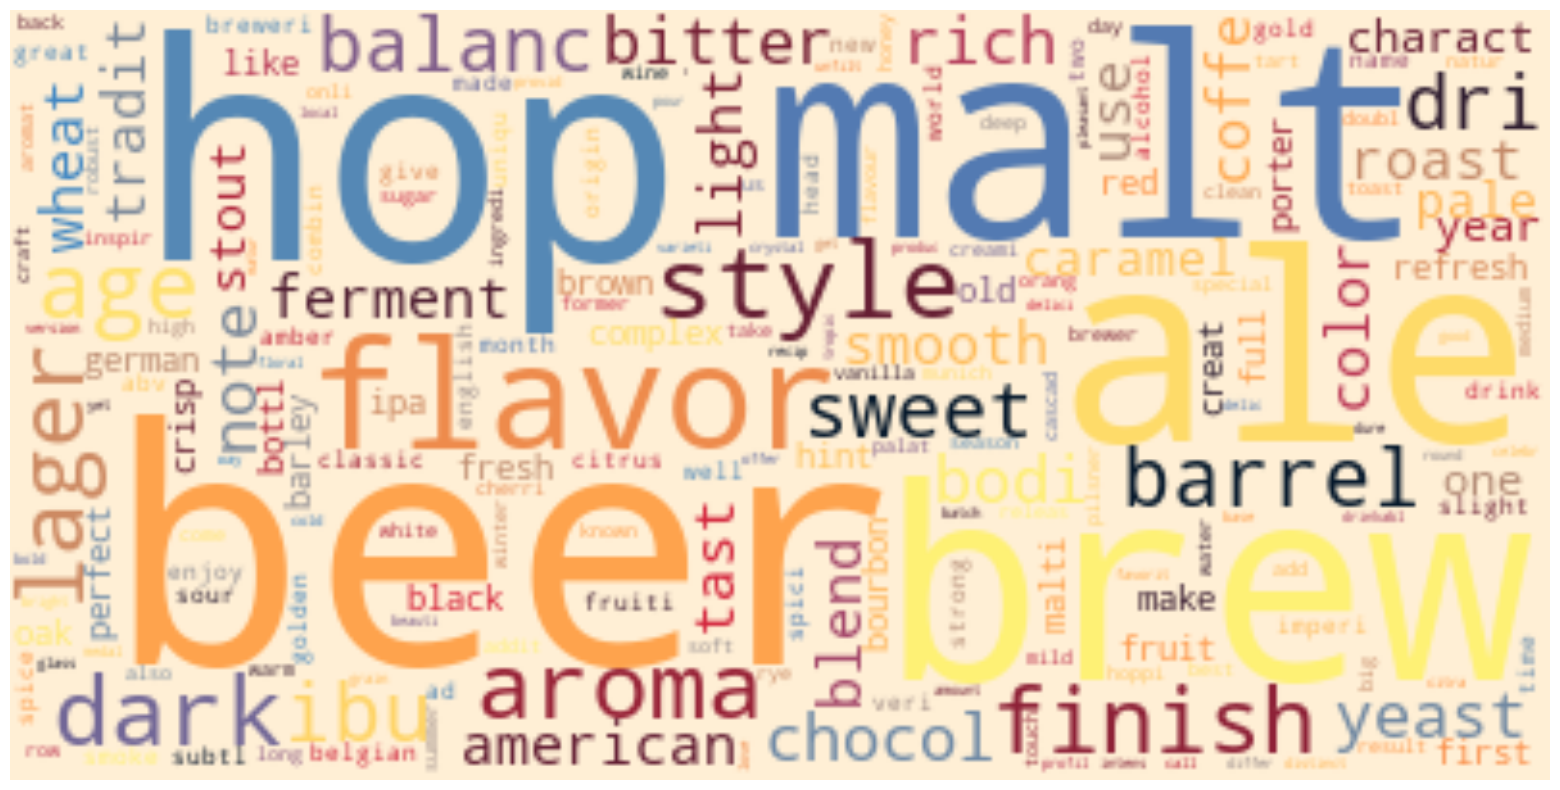

In [13]:
#creating word cloud to see all words and compare to list below
hero.wordcloud(text['clean_description'])

In [14]:
#inspecting top words
hero.top_words(text['clean_description'])[:10]

beer      2691
hop       2229
malt      1854
brew      1740
ale       1703
flavor    1188
style      813
dark       704
aroma      695
age        642
Name: clean_description, dtype: int64

> Unsurprisingly 'beer' is the most common word in the descriptions. This word would classify as a corpus specific stop word. These words can beremoved by adding them to the stopwords list, or they can be further filtered out using the max_df parameter in the Tf-idf vectorizer (which is what I did for this project).

### TF-IDF Vectorization

TF-IDF stands for Term Frequency-Inverse Document Frequency. The vectorizer turns each unique word into a feature and the values are proportional to the number of times the word is used and inversely proportional to the number of documents (descriptions) in which the word is used. I chose to use this vectorizer as it is based on the idea that rare words contain more information about the content of a document than words that are used many times throughout all documents (an example in this case would be the word beer). 

In [15]:
# getting tfidf scores using sklearn Tfidf vectorizer
tf = TfidfVectorizer(min_df=0.005, max_df= 1500)
text_vec = tf.fit_transform(text.clean_description)

### Changing min & max df to account for corpus specific stop words

After initial inspection the term beer still appears in the vectorized dataframe. In order to remove this word I decided to alter the parameters of **min_df** (removes terms that appear too infrequently) and **max_df** (removes words that appear too frequently -- also known as corpus-specific stop words).

Example of how these parameters operate: 

**min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents". min_df = 5 means "ignore terms that appear in less than 5 documents". The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

> The number 0.005 was chosen after through an iterative process after reviewing the maxtrix that was created.


**max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents". max_df = 25 means "ignore terms that appear in more than 25 documents". The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

> After going through in iterative process, changing the max_df to ignore words that appear in more than 1500 documents has removed beer from being part of the matrix. However, it still includes other top words that describe beer such as malt, hop, and dark

In [16]:
vec = pd.DataFrame(text_vec.toarray(), columns=tf.get_feature_names(),index= text.index)
vec.head()

,19th,abbey,abund,abv,accent,accentu,accompani,accord,achiev,acid,...,wort,would,www,year,yeast,yellow,yet,yield,young,zest
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
252,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.104939,0.000000,0.0,0.000000,0.0,0.0,0.0
253,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.108784,0.0,0.157051,0.0,0.0,0.0
255,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
256,0.0,0.0,0.0,0.101863,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.081052,0.0,0.000000,0.0,0.0,0.0


In [17]:
vec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 251 to 700
Columns: 982 entries, 19th to zest
dtypes: float64(982)
memory usage: 25.1 MB


***
## Object and Numerical Preprocessing

### Read in data

In [18]:
df = pd.read_csv('../BeerData/tasting_cleaned.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,Name,beer_id,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
0,Alaskan Amber,251,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
1,Double Bag,252,Brown Ale,8,Long Trail Brewing Co.,"This malty, full-bodied double alt is also kno...",Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
2,Long Trail Ale,253,Brown Ale,8,Long Trail Brewing Co.,Long Trail Ale is a full-bodied amber ale mode...,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
3,Scurry,255,Brown Ale,8,Off Color Brewing,Just cause it's dark and German doesn't mean i...,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
4,Sleigh'r Dark Doüble Alt Ale,256,Brown Ale,8,Ninkasi Brewing Company,Called 'Dark Double Alt' on the label.Seize th...,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


In [19]:
#beer_id will be used as a unique identifier for recommendations, not as an actual feature. 
# resetting index to be be unique_id so it is not preprocessed
df.set_index('beer_id', inplace=True)

#checking df
df.head(1)

,Name,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,,,,,
251,Alaskan Amber,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5


> Columns to drop include: Name, Style Key, Brewery (in order to diversify recommendations), Description (text data will be rejoined after processing)

In [20]:
prepross = df.copy()

In [21]:
prepross.head()

,Name,Style,Style Key,Brewery,Description,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,,,,,
251,Alaskan Amber,Brown Ale,8,Alaskan Brewing Co.,"Richly malty and long on the palate, with just...",Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
252,Double Bag,Brown Ale,8,Long Trail Brewing Co.,"This malty, full-bodied double alt is also kno...",Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
253,Long Trail Ale,Brown Ale,8,Long Trail Brewing Co.,Long Trail Ale is a full-bodied amber ale mode...,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
255,Scurry,Brown Ale,8,Off Color Brewing,Just cause it's dark and German doesn't mean i...,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
256,Sleigh'r Dark Doüble Alt Ale,Brown Ale,8,Ninkasi Brewing Company,Called 'Dark Double Alt' on the label.Seize th...,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


In [22]:
prepross.drop(columns=['Name', 'Style Key', 'Brewery', 'Description'], inplace=True)

In [23]:
prepross.head()

,Style,ABV,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,,,
251,Brown Ale,Medium,3.65,13,32,9,47,74,33,0,33,57,8,111,37.5
252,Brown Ale,Medium,3.90,12,57,18,33,55,16,0,24,35,12,84,37.5
253,Brown Ale,Low,3.58,14,37,6,42,43,11,0,10,54,4,62,37.5
255,Brown Ale,Medium,3.67,21,69,10,63,120,14,0,19,36,15,218,37.5
256,Brown Ale,Medium,3.78,25,51,26,44,45,9,1,11,51,20,95,37.5


### Getting Dummy Variables for Object Features

In [24]:
prepross.dtypes
#will need to pull 'style' and 'abv'

Style           object
ABV             object
Avg Rating     float64
Astringency      int64
Body             int64
Alcohol          int64
Bitter           int64
Sweet            int64
Sour             int64
Salty            int64
Fruits           int64
Hoppy            int64
Spices           int64
Malty            int64
AvgIBU         float64
dtype: object

In [25]:
#using function to grab object features and dummy out
categories = object_process(prepross)
categories.head()

,Style_Bock,Style_Brown Ale,Style_Dark Ale,Style_Dark Lager,Style_Hybrid Beer,Style_India Pale Ale,Style_Pale Ale,Style_Pale Lager,Style_Porter,Style_Specialty Beer,Style_Stout,Style_Strong Ale,Style_Wheat Beer,Style_Wild/Sour Beer,ABV_High,ABV_Low,ABV_Medium
beer_id,,,,,,,,,,,,,,,,,
251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
252,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
253,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
255,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
256,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling Numeric Features

In [26]:
#using function to grab number features and minmax scale
numeric = numeric_process(prepross)

In [27]:
numeric.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,AvgIBU
beer_id,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,0.043478,0.365132,0.454545
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,0.065217,0.276316,0.454545
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,0.021739,0.203947,0.454545
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,0.081522,0.717105,0.454545
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,0.108696,0.312500,0.454545


***

## Combining Transformed Data Frames
Combine the cleaned and transformed description matrix, categorical dummy variables, and the scaled numberical variables into one frame for modeling. 

In [28]:
#combining numeric and catetories first
model_df = numeric.merge(categories, left_index=True, right_index=True)

In [29]:
model_df.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,...,Style_Pale Lager,Style_Porter,Style_Specialty Beer,Style_Stout,Style_Strong Ale,Style_Wheat Beer,Style_Wild/Sour Beer,ABV_High,ABV_Low,ABV_Medium
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,...,0,0,0,0,0,0,0,0,0,1
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,...,0,0,0,0,0,0,0,0,0,1
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,...,0,0,0,0,0,0,0,0,1,0
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,...,0,0,0,0,0,0,0,0,0,1
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,...,0,0,0,0,0,0,0,0,0,1


In [30]:
#now adding description 
model_df = model_df.merge(vec, left_index=True, right_index=True)

In [31]:
#inspecting complete df for use in model
model_df.head()

,Avg Rating,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,...,wort,would,www,year,yeast,yellow,yet,yield,young,zest
beer_id,,,,,,,,,,,,,,,,,,,,,
251,0.646341,0.156627,0.162437,0.064748,0.313333,0.281369,0.102167,0.000000,0.148649,0.331395,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
252,0.722561,0.144578,0.289340,0.129496,0.220000,0.209125,0.049536,0.000000,0.108108,0.203488,...,0.0,0.0,0.0,0.104939,0.000000,0.0,0.000000,0.0,0.0,0.0
253,0.625000,0.168675,0.187817,0.043165,0.280000,0.163498,0.034056,0.000000,0.045045,0.313953,...,0.0,0.0,0.0,0.000000,0.108784,0.0,0.157051,0.0,0.0,0.0
255,0.652439,0.253012,0.350254,0.071942,0.420000,0.456274,0.043344,0.000000,0.085586,0.209302,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
256,0.685976,0.301205,0.258883,0.187050,0.293333,0.171103,0.027864,0.015625,0.049550,0.296512,...,0.0,0.0,0.0,0.000000,0.081052,0.0,0.000000,0.0,0.0,0.0


In [32]:
model_df.shape

(3346, 1012)

In [33]:
#sending to csv for use in app 
model_df.to_csv('./data/model_df.csv')

***

# Building Recommender

Creating meta data dataframe for use in displaying recommendations. It will display the name of the beer, the style, the brewery that made it, the description, the ABV, and the average rating of the beer. Using the foundation code from [this](https://github.com/danielburdeno/Kindle-eBook-Recommendations/blob/main/ContentBased.ipynb) recommendation system. A user should be able to enter the name of the beer they already like, the number of recommendations they want to receive, and have that many beers returned for them to try.

In [34]:
df_meta_data = df.copy()

In [35]:
df_meta_data.drop(columns=['Style Key', 'Description', 'Astringency', 'Body', 'Alcohol',
                           'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits',
                           'Hoppy', 'Spices', 'Malty', 'AvgIBU'], inplace=True)
df_meta_data.head()

,Name,Style,Brewery,ABV,Avg Rating
beer_id,,,,,
251,Alaskan Amber,Brown Ale,Alaskan Brewing Co.,Medium,3.65
252,Double Bag,Brown Ale,Long Trail Brewing Co.,Medium,3.90
253,Long Trail Ale,Brown Ale,Long Trail Brewing Co.,Low,3.58
255,Scurry,Brown Ale,Off Color Brewing,Medium,3.67
256,Sleigh'r Dark Doüble Alt Ale,Brown Ale,Ninkasi Brewing Company,Medium,3.78


In [41]:
# sending meta data used for disply in app to csv
df_meta_data.to_csv('./data/df_meta_data.csv')

In [36]:
# # Input for name of beer that returns the 'beer_id' index number for 
# # the beer to be used to call dataframe
name = input('Name of beer: ')
beer = df_meta_data.index[df_meta_data['Name'] == name]
beer

Name of beer: Sculpin


Int64Index([1252], dtype='int64', name='beer_id')

In [37]:
# taking selected row, making it array and reshaping it for use in consine simularity function
y = np.array(model_df.loc[beer])
y = y.reshape(1,-1)
y

array([[0.87804878, 0.24096386, 0.17258883, ..., 0.        , 0.        ,
        0.        ]])

In [38]:
# Calculating the similarity measures based on Cosine Similarity
cos_sim = cosine_similarity(model_df, y)
# Create a dataframe with similairty scores for each beer_id
cos_sim = pd.DataFrame(data=cos_sim, index = model_df.index)
cos_sim.head()

,0
beer_id,
251,0.532646
252,0.553384
253,0.313603
255,0.510909
256,0.530041


In [39]:
# Input used to ask how many recommendations the user would like returned
n_recs = int(input('How many recommendations? '))
# The cos_sim scores then need to be sorted in descending order to return top n number
cos_sim.sort_values(by = 0, ascending = False, inplace=True)
# In order to not return the original beer input first need to obtain the index values for the requested # of recommendations
results = cos_sim.index.values[1:n_recs+1]
results

How many recommendations? 5


array([1504, 1264, 1295, 1319, 1377])

In [40]:
results_df = df_meta_data.loc[results]
results_df.reset_index(inplace=True)
results_df

,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,1504,Enjoy By IPA,India Pale Ale,Stone Brewing,Medium,4.44
1,1264,Union Jack IPA,India Pale Ale,Firestone Walker Brewing Co.,Medium,4.24
2,1295,Hop Hunter,India Pale Ale,Sierra Nevada Brewing Co.,Medium,4.06
3,1319,The Audacity Of Hops,India Pale Ale,Cambridge Brewing Company,Medium,4.07
4,1377,Society & Solitude #2,India Pale Ale,Hill Farmstead Brewery,Medium,4.33


***

## Recommender Function
Combining code from above to make a function that takes in the name of a beer and the number of recommendations as input and returns that number of beers. There are three functions total each with a different distance metric. To test each I am going to pass in the same set of beers and compare the recommendations.

### Cosine Similarity Recommender

In [39]:
def beer_recommender(): 
    name = input('Name of beer: ')
    beer = df_meta_data.index[df_meta_data['Name'] == name]
    n_recs = int(input('How many recommendations? '))
    
    y = np.array(model_df.loc[beer]).reshape(1,-1)
    cos_sim = cosine_similarity(model_df, y)
    cos_sim = pd.DataFrame(data=cos_sim, index = model_df.index)
    cos_sim.sort_values(by = 0, ascending = False, inplace=True)
   
    results = cos_sim.index.values[1:n_recs+1]
    results_df = df_meta_data.loc[results]
    results_df.reset_index(inplace=True)
    return results_df

In [77]:
beer_recommender()

Name of beer: Shiner Bock
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,166,Schell's Bock,Bock,August Schell Brewing Company,Medium,3.89
1,103,Mardi Gras Bock,Bock,Abita Brewing Co.,Medium,3.48
2,486,After Dark,Brown Ale,Nelson Brewing Company,Low,3.68
3,4,Salvator,Bock,Paulaner Brauerei,Medium,3.95
4,187,Battlefield Bock,Bock,Red Oak Brewery,Medium,3.92


In [76]:
beer_recommender()

Name of beer: Purple Haze
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,3335,UFO Raspberry Hefeweizen,Specialty Beer,Harpoon Brewery & Beer Hall,Low,3.61
1,3543,Family Secret Borodino Household Kvass,Specialty Beer,Ochakovo,Low,3.98
2,3310,Hell Or High Watermelon Wheat Beer,Specialty Beer,21st Amendment Brewery,Low,3.40
3,3342,Blackbeary Wheat,Specialty Beer,Long Trail Brewing Co.,Low,3.14
4,3337,Shiner Prickly Pear,Specialty Beer,Spoetzl Brewery,Low,3.39


In [79]:
beer_recommender()

Name of beer: Brooklyn Lager
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,726,Colorado Native Amber Lager,Dark Lager,AC Golden Brewing Company,Medium,3.67
1,1012,Von Trapp Vienna Style Lager,Dark Lager,von Trapp Brewing,Medium,3.83
2,1005,Sierra Nevada Vienna Style Lager,Dark Lager,Sierra Nevada Brewing Co.,Medium,3.80
3,713,Coney Island Lager,Dark Lager,Coney Island Brewing Company,Medium,3.68
4,735,LTD Series - 05,Dark Lager,Full Sail Brewing Company,Medium,3.62


In [80]:
beer_recommender()

Name of beer: Sierra Nevada Pale Ale
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,2004,Alpha King,Pale Ale,3 Floyds Brewing Co.,Medium,4.26
1,2058,"Luciérnaga, The Firefly",Pale Ale,Jolly Pumpkin Artisan Ales,Medium,4.06
2,2108,Smuttynose Shoals Pale Ale,Pale Ale,Smuttynose Brewing Company,Medium,3.84
3,2162,Gaelic Ale,Pale Ale,Highland Brewing,Medium,3.83
4,2192,Jamaica Red Ale,Pale Ale,Mad River Brewing Company,Medium,3.85


In [84]:
beer_recommender()

Name of beer: White Rascal
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,4830,Hysteria,Wheat Beer,Three Notch'd Brewing Company - Charlottesvill...,Medium,3.88
1,4808,No. 15,Wheat Beer,The Schlafly Tap Room,Medium,3.89
2,4906,Samuel Adams DunkelweizenBoston Beer Company (...,Wheat Beer,Boston Beer Company (Samuel Adams),Medium,3.52
3,4852,Gumballhead,Wheat Beer,3 Floyds Brewing Co.,Medium,4.21
4,4877,Pineapple Mana Wheat,Wheat Beer,Maui Brewing Co.,Medium,3.57


### Euclidean Distance Recommender

In [98]:
def beer_recommender2(): 
    name = input('Name of beer: ')
    beer = df_meta_data.index[df_meta_data['Name'] == name]
    n_recs = int(input('How many recommendations? '))
    
    y = np.array(model_df.loc[beer]).reshape(1,-1)
    euclid = euclidean_distances(model_df, y)
    euclid = pd.DataFrame(data=euclid, index = model_df.index)
    euclid.sort_values(by = 0, ascending = False, inplace=True)
    results = euclid.index.values[1:n_recs+1]
    results_df = df_meta_data.loc[results]
    results_df.reset_index(inplace=True)
    return results_df

In [99]:
beer_recommender2()

Name of beer: Shiner Bock
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,5542,Montmorency Vs Balaton,Wild/Sour Beer,Jester King Brewery,Medium,4.53
1,5235,Sour Reserve,Wild/Sour Beer,Upland Brewing Company,Medium,4.39
2,1537,The Oracle,India Pale Ale,Bell's Brewery - Eccentric Café & General Store,Medium,4.18
3,3083,Victory At Sea - Peanut Butter,Porter,Ballast Point Brewing Company,High,3.97
4,4386,Brewer's Reserve Bourbon Barrel Quadruple Ale,Strong Ale,Central Waters Brewing Co.,High,4.19


In [85]:
beer_recommender2()

Name of beer: Purple Haze
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,1537,The Oracle,India Pale Ale,Bell's Brewery - Eccentric Café & General Store,Medium,4.18
1,4131,Rogue Ales Imperial Stout,Stout,Rogue Ales,High,4.07
2,4078,Earl Coffee Oatmeal Stout,Stout,Hill Farmstead Brewery,Medium,4.29
3,5533,Sour In The Rye - Kumquats,Wild/Sour Beer,Bruery Terreux,Medium,4.42
4,3878,Mexican Cake,Stout,Westbrook Brewing Co.,High,4.42


In [86]:
beer_recommender2()

Name of beer: Sierra Nevada Pale Ale
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,2977,Barrel-Aged Framinghammer - Mole,Porter,Jack's Abby Brewing,High,4.28
1,4386,Brewer's Reserve Bourbon Barrel Quadruple Ale,Strong Ale,Central Waters Brewing Co.,High,4.19
2,4373,Box Set Track #8 - Number Of The Beast,Strong Ale,The Lost Abbey,High,4.35
3,3209,Billy's Chilies Beer (Timberline Series),Specialty Beer,Twisted Pine Brewing Company,Low,3.42
4,3878,Mexican Cake,Stout,Westbrook Brewing Co.,High,4.42


In [87]:
beer_recommender2()

Name of beer: Brooklyn Lager
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,4386,Brewer's Reserve Bourbon Barrel Quadruple Ale,Strong Ale,Central Waters Brewing Co.,High,4.19
1,4373,Box Set Track #8 - Number Of The Beast,Strong Ale,The Lost Abbey,High,4.35
2,3879,Abraxas,Stout,Perennial Artisan Ales,High,4.50
3,3083,Victory At Sea - Peanut Butter,Porter,Ballast Point Brewing Company,High,3.97
4,3309,Serendipity,Specialty Beer,New Glarus Brewing Company,Low,4.38


In [100]:
beer_recommender2()

Name of beer: White Rascal
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,4131,Rogue Ales Imperial Stout,Stout,Rogue Ales,High,4.07
1,1350,Aldebaran,India Pale Ale,Kuhnhenn Brewing Company,High,3.96
2,4386,Brewer's Reserve Bourbon Barrel Quadruple Ale,Strong Ale,Central Waters Brewing Co.,High,4.19
3,4134,Bourbon Barrel Aged Siberian Night Imperial Stout,Stout,Thirsty Dog Brewing Company,High,4.26
4,4237,Double Or Nothing,Strong Ale,Otter Creek Brewing,High,4.02


### Linear Kernal Recommender

In [73]:
def beer_recommender3(): 
    name = input('Name of beer: ')
    beer = df_meta_data.index[df_meta_data['Name'] == name]
    n_recs = int(input('How many recommendations? '))
    
    y = np.array(model_df.loc[beer]).reshape(1,-1)
    linear = linear_kernel(model_df, y)
    linear = pd.DataFrame(data=linear, index = model_df.index)
    linear.sort_values(by = 0, ascending = False, inplace=True)
    results = linear.index.values[1:n_recs+1]
    results_df = df_meta_data.loc[results]
    results_df.reset_index(inplace=True)
    return results_df

In [89]:
beer_recommender3()

Name of beer: Shiner Bock
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,145,Heller Bock Saphir,Bock,Brauerei Hofstetten Krammer GmbH & Co. KG,Medium,3.95
1,2341,Remain In Light,Pale Lager,Cambridge Brewing Company,Low,3.73
2,2844,Hometown Blonde,Pale Lager,New Glarus Brewing Company,Low,4.01
3,166,Schell's Bock,Bock,August Schell Brewing Company,Medium,3.89
4,3908,Dragonhead Stout,Stout,Orkney Brewery,Low,3.86


In [90]:
beer_recommender3()

Name of beer: Purple Haze
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,3309,Serendipity,Specialty Beer,New Glarus Brewing Company,Low,4.38
1,3303,Raspberry Tart,Specialty Beer,New Glarus Brewing Company,Low,4.41
2,3317,Strawberry Rhubarb,Specialty Beer,New Glarus Brewing Company,Low,4.35
3,3335,UFO Raspberry Hefeweizen,Specialty Beer,Harpoon Brewery & Beer Hall,Low,3.61
4,3306,Wisconsin Belgian Red,Specialty Beer,New Glarus Brewing Company,Low,4.42


In [91]:
beer_recommender3()

Name of beer: Sierra Nevada Pale Ale
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,2044,Mosaic Dry Hopped Fort Point,Pale Ale,Trillium Brewing Company,Medium,4.51
1,2002,Zombie Dust,Pale Ale,3 Floyds Brewing Co.,Medium,4.63
2,1680,Moondog Ale,Pale Ale,Great Lakes Brewing Co.,Medium,3.94
3,2108,Smuttynose Shoals Pale Ale,Pale Ale,Smuttynose Brewing Company,Medium,3.84
4,1682,The Wise ESB,Pale Ale,Elysian Brewing Company,Medium,3.89


In [92]:
beer_recommender3()

Name of beer: Brooklyn Lager
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,975,BREWtality - Espresso Black Bier,Dark Lager,Midnight Sun Brewing Co.,Medium,4.14
1,850,Tuberfest,Dark Lager,Lagunitas Brewing Company,Medium,3.72
2,726,Colorado Native Amber Lager,Dark Lager,AC Golden Brewing Company,Medium,3.67
3,766,LTD Series - 06,Dark Lager,Full Sail Brewing Company,Medium,3.85
4,1012,Von Trapp Vienna Style Lager,Dark Lager,von Trapp Brewing,Medium,3.83


In [93]:
beer_recommender3()

Name of beer: White Rascal
How many recommendations? 5


,beer_id,Name,Style,Brewery,ABV,Avg Rating
0,5056,White Rascal,Wheat Beer,Avery Brewing Company,Medium,3.67
1,4830,Hysteria,Wheat Beer,Three Notch'd Brewing Company - Charlottesvill...,Medium,3.88
2,4756,Anniversary Ale,Wheat Beer,Short's Brewing Company,Medium,3.97
3,4852,Gumballhead,Wheat Beer,3 Floyds Brewing Co.,Medium,4.21
4,5093,Two Jokers Double-Wit,Wheat Beer,Boulevard Brewing Co.,Medium,4.03


***

# Recommender Evaluation

Upon comparing the output of the three systems, the model using Euclidean distance (beer_recommender2) is giving very different recommendations than the other two. These recommendations are not even close in style (which you would expect given the type of recommendation system), so I would not use this metric in a model for beer recommendations.

The cosine similarity (beer_recommender) and linear kernel (beer_recommender2) systems are giving beers that are close in style, but they are not returning the same beers (with some exceptions). Based on personal experience and input from people with domain knowledge I am confident that the cosine similarity model could make an app that would make successful recommendations.

***

# Conclusion

I am confident that using the function based on cosine similarity would provide successful recommendations for users. Because content based recommenders give results based on item similarity the fact that results are all within the same general beer style was expected. Styles were binned based on overall style from the BeerAdvocate website, but one thing that could be explored in the future is seeing if styles change after using unsupervised clustering. 

A content based recommendation system is a good option for someone who is just entering the craft beer scene as they can find similar options to beers they already enjoy. Through the recommender display they can also find new breweries to explore as most recommendations are from breweries that do not make the input beer. For the more experienced drinker, getting more personalized and varied recommendations from a [collaborative filtration](./CollabFiltering.ipynb) system might be a better option.

Another future step would be obtaining descriptions for the beers that were dropped because their descriptions were missing. This would add 2,000 beers back into the dataset and could allow for better recommendations. The data overall could benefit from an update as the initial scraping of BeerAdvocate.com and creation of the dataset was done a few years ago and several new drinks have come on and off the market. 